# Attack CNN Model

#### Description:
#### - In this Code, we implement CNN model from attacker's perspective to successfully conduct a Website Fingerprinting(WF) attack
#### - Input: Preprocessed WFs
#### - Output: Reconstructed WFs



In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from csv import writer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv1D,MaxPooling1D,BatchNormalization
from tensorflow.keras.models import Sequential 

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import ticker as ticker
import matplotlib.pyplot as plt

import h5py
import os
from sklearn.metrics import f1_score



# Input : Preprocessed Website Fingerprint(WF) dataset

In [4]:
train_X = pd.read_csv('../Data_Collection/trainX_2_US_Chrome.csv', header=None)
train_Y = pd.read_csv('../Data_Collection/trainY_2_US_Chrome.csv', header=None)

In [5]:
trainX = train_X.to_numpy()
trainY = train_Y.to_numpy()

In [6]:
print(trainX.shape)
print(trainY.shape)

(200, 6000)
(200, 1)


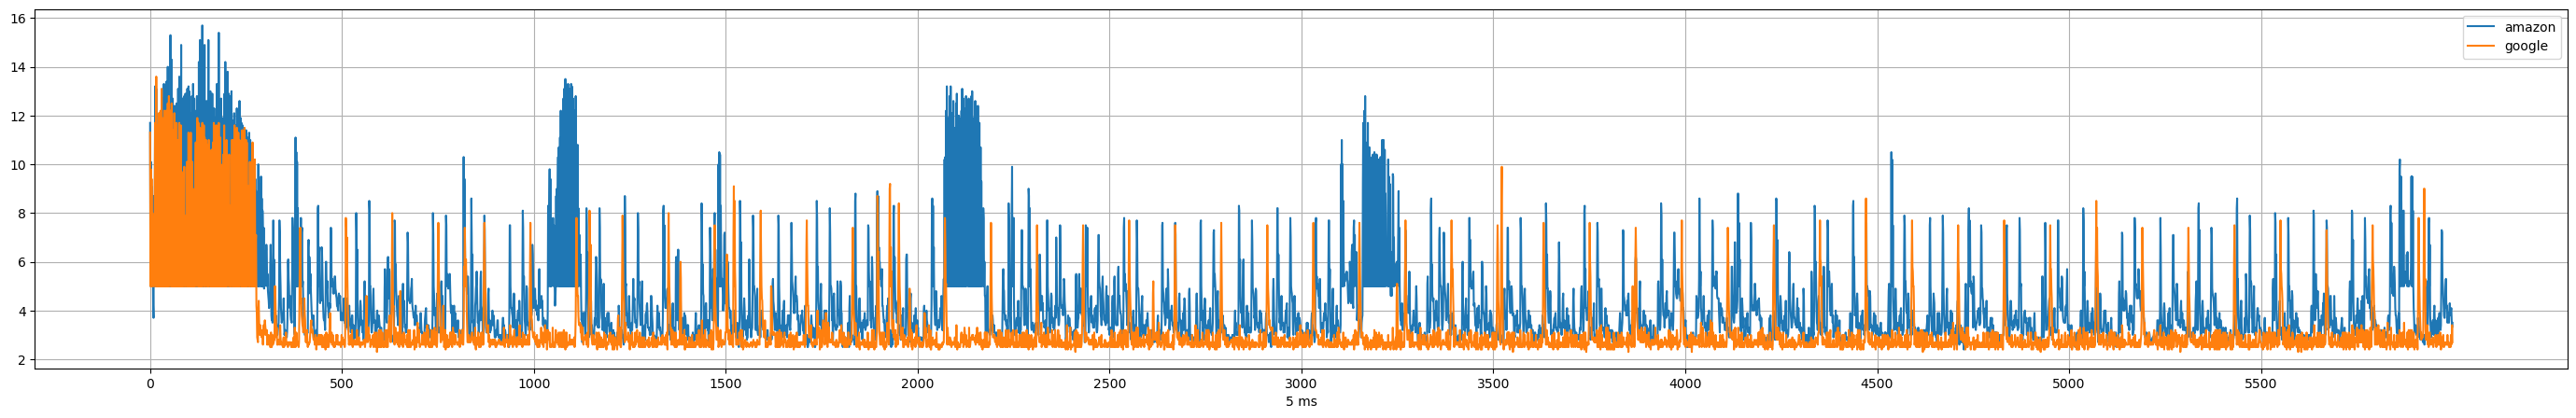

In [7]:
fig = plt.figure(figsize=(35,5))
plt.plot(trainX[0],label='amazon')
plt.plot(trainX[100],label='google')

plt.legend()
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
plt.xlabel("5 ms")
#fig.savefig('Graph_Amaozon_Google.png')
plt.show()

In [8]:
trainX = np.expand_dims(trainX,axis=2)

In [9]:
minimum = np.amin(trainX)
maximum = np.amax(trainX)

trainX_normalized = (trainX-minimum)/(maximum-minimum)
print(trainX_normalized.shape)

trainX_test = trainX_normalized


(200, 6000, 1)


In [10]:
trainY= keras.utils.to_categorical(trainY)
print(trainY.shape)

(200, 2)


In [11]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(trainX_test, trainY ,test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print("--------------Data--------------")
print("Orignal X shape: {}".format(trainX.shape))
print("Origianl Y shape: {}".format(trainY.shape))

print("--------------Train Data--------------")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("--------------Validation Data--------------")
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))

print("--------------Test Data--------------")
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))



--------------Data--------------
Orignal X shape: (200, 6000, 1)
Origianl Y shape: (200, 2)
--------------Train Data--------------
X_train shape: (120, 6000, 1)
y_train shape: (120, 2)
--------------Validation Data--------------
X_val shape: (40, 6000, 1)
y val shape: (40, 2)
--------------Test Data--------------
X_test shape: (40, 6000, 1)
y_test shape: (40, 2)


In [13]:
def model_create(x=None):
    # This depends on the number of Website
    numberOfWebsite = 2

    # This depends on the number of samples 
    input = keras.Input(shape = (6000,1))
    
    x = layers.Conv1D(128, 3, activation="relu", padding="same")(input)
    x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
    x = MaxPooling1D(pool_size=3)(x)
    
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = MaxPooling1D(pool_size=3)(x)
    
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    x = Dense(numberOfWebsite,activation='softmax')(x)
    model = keras.Model(inputs = input, outputs = x)
    
    return model



In [14]:
model = model_create()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 6000, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, 6000, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 2000, 32)          6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 666, 32)          0         
 1D)                                                         

2023-09-20 13:48:37.916232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 13:48:38.557582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [15]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

In [16]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
#history = model.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), batch_size= 32)
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))


(120, 6000, 1) (120, 2)
(40, 6000, 1) (40, 2)
Epoch 1/40


2023-09-20 13:48:45.909877: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-09-20 13:48:46.874275: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-20 13:48:46.875048: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-20 13:48:46.875064: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-20 13:48:46.876136: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-20 13:48:46.876193: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-09-20 13:48:47.621579: I tensorflow/stream_executor/cuda/c

4/4 [==============================] - 4s 137ms/step - loss: 0.6041 - accuracy: 0.5917 - val_loss: 0.3091 - val_accuracy: 0.9500
Epoch 2/40
4/4 [==============================] - 0s 27ms/step - loss: 0.2306 - accuracy: 0.9667 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 3/40
4/4 [==============================] - 0s 26ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/40
4/4 [==============================] - 0s 26ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 3.7668e-04 - val_accuracy: 1.0000
Epoch 5/40
4/4 [==============================] - 0s 26ms/step - loss: 0.0148 - accuracy: 0.9917 - val_loss: 0.2153 - val_accuracy: 0.9750
Epoch 6/40
4/4 [==============================] - 0s 27ms/step - loss: 0.1069 - accuracy: 0.9917 - val_loss: 0.0366 - val_accuracy: 0.9750
Epoch 7/40
4/4 [==============================] - 0s 25ms/step - loss: 2.6136e-05 - accuracy: 1.0000 - val_loss: 6.4831e-05 - val_accuracy: 1.0000
Epoch 8/40
4/4 [=========

# Pre-trained Model Save

In [17]:
#np.save('History_Test_100_3000_US_final.npy',history.history)
model.save('CNN_Pretrained_Model_chrome_W2.h5')

In [18]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1324880233587464e-07
Test accuracy: 1.0


In [19]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

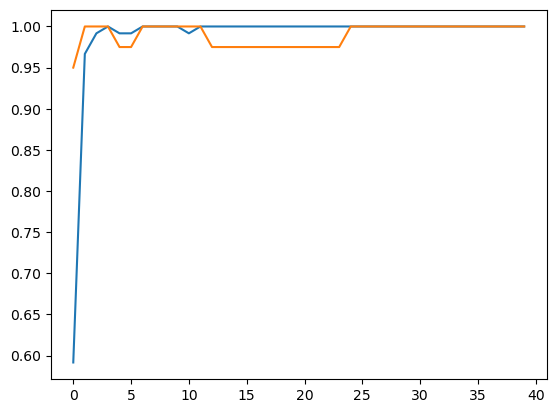

In [20]:
# plot learning curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')


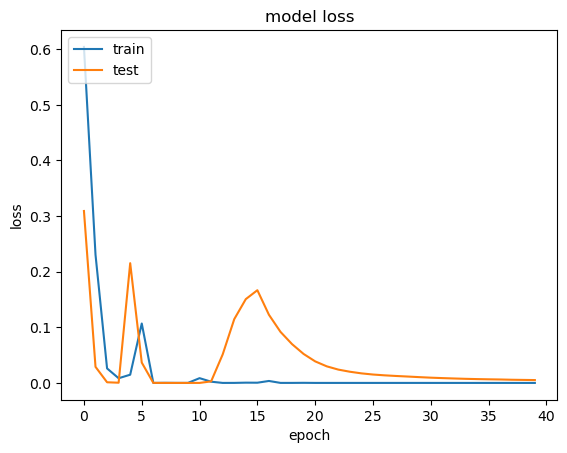

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')
plt.show()